In [ ]:
"""
goal to check which tasks have been presented across multipel expts - to see those in G4 tasks
"""


In [1]:
%load_ext autoreload
%autoreload 2

%cd ..

from tools.utils import * 
from tools.plots import *
from tools.analy import *
from tools.calc import *
from tools.analyplot import *
from tools.preprocess import *
from tools.dayanalysis import *
from analysis.line2 import *
from analysis.probedatTaskmodel import *
from pythonlib.drawmodel.analysis import *
from pythonlib.tools.stroketools import *

/data1/code/python/drawmonkey
NOTE: need to not overwrite strokes_all_task, because then the orders saved will stop being accurate. Modify


In [ ]:
SDIR = "/data2/analyses/database/tasks_all_time"
# import os
os.makedirs(SDIR, exist_ok=True)




In [ ]:
overwrite=True

In [ ]:
# === 1) load probedat

DAT = []
# exptlist = ["arc1", "arc2", 
#             "biasdir3", "biasdir4", "biasdir5", "biasdir6", "biasdir7_1", "biasdir7_2",
#             "figures3", "figures4", "figures5", "figures6", "figures7v2", "figures8", "figures89",
#             "lines2", "lines5", "lines5redo",
#             "shapes1", "shapes2", "shapes3", "shapes4"
#            ]
exptlist = ["figures89"]
# exptlist = [
#             "lines2", "lines5", "lines5redo",
#             "shapes1", "shapes2", "shapes3", "shapes4"
#            ]
for expt in exptlist:
    for animal in ["Red"]:
#         animal = "Pancho"
        
        if not overwrite:
            # check whether this exists
            fcheck = f"{SDIR}/{animal}-{expt}.pkl"
#             print(fcheck)
            exists = os.path.exists(fcheck)
            if exists:
                print(f"skipping since exists: {fcheck}")
                continue
            
        FD, exptMetaDat = loadMultDataForExpt(expt, animal, whichdates="all", metadatonly=False)

        PD = loadProbeDatWrapper(FD, exptMetaDat)
        P = ProbedatTaskmodel(PD, exptMetaDat)
        Pp = P.pandas()
        
        if len(Pp)==0:
            continue

        # ================ extract just the essentials 
        # Return a stripped down dataframe

        # - only keep Fixed tasks
        idx_good = P.filterPandas({"random_task":[False]}, return_indices=True)
        P = ProbedatTaskmodel([P.Probedat[i] for i in idx_good], P.Metadat)
        Pp = P.pandas()

        keys_to_keep = ["animal", "expt", "date", "block", "trialcode", "taskgroup", "kind", "unique_task_name", 
                        "task_stagecategory", "prototype", "epoch"]
        for k in list(Pp.columns):
            if k not in keys_to_keep:
                if k in Pp.columns:
                    del Pp[k]

        # - also extract task pts
        taskstrokes = P.getTrialsHelper("getTrialsTaskAsStrokes", "all")
        Pp["strokes_task"] = taskstrokes

        # ===== save
        Pp.to_pickle(f"{SDIR}/{animal}-{expt}.pkl")

        # ===== collect
        DAT.append(Pp)

        #

## LOAD AND ANALYZE


In [2]:
from pythonlib.tools.expttools import makeTimeStamp
SDIR = "/data2/analyses/database/tasks_all_time"
SDIRPLOTS = f"{SDIR}/figures/{makeTimeStamp(datefirst=False)}"
os.makedirs(SDIRPLOTS, exist_ok=True)


In [ ]:
import glob
from pythonlib.tools.snstools import rotateLabel

plotall = False

for animal in ["Red"]:

    dirs = glob.glob(f"{SDIR}/{animal}*.pkl")
    DF = pd.DataFrame()
    for d in dirs:
        print(d)
        df = pd.read_pickle(d)
        DF = DF.append(df)

    DF = DF.reset_index()
    DF = DF.sort_values("date")

    # == plot all
    if plotall:
        H = 160
        ax = sns.catplot(data=DF, x="expt", y="unique_task_name", hue="task_stagecategory", aspect = 1/5, height = H)
        rotateLabel(ax)
        ax.savefig(f"{SDIRPLOTS}/overview-{animal}.pdf")

    # === just subset
    H = 100
    DFthis = DF[DF["expt"].isin(["lines5", "arc2", "shapes2", "shapes3", "shapes4", "figures9"])]
    ax = sns.catplot(data=DFthis, x="expt", y="unique_task_name", hue="task_stagecategory", aspect = 1/5, height = H)
    rotateLabel(ax)
    ax.savefig(f"{SDIRPLOTS}/overview-lines5_arc2_shapes234_figures9_{animal}.pdf")

    # == separate by taskgroup:
    for taskgroup in set(DF["taskgroup"]):
        DFthis = DF[DF["taskgroup"]==taskgroup]
        ax = sns.catplot(data=DFthis, x="expt", y="unique_task_name", hue="task_stagecategory", aspect = 1/5, height = 80)

        rotateLabel(ax)
        ax.savefig(f"{SDIRPLOTS}/overview-taskgroup_{taskgroup}-{animal}.pdf")

    # == plot, only tasks that occur across multiple epxts
    tasklist = set(DF["unique_task_name"])
    tasksgood = []
    for task in tasklist:
        exptsthis = set(DF[DF["unique_task_name"]==task]["expt"].values)
        if len(exptsthis)>1:
            # then keep
            tasksgood.append(task)

    print("these tasks present over multiple expts")
    print(len(tasksgood))
    print("total num tasks")
    print(len(tasklist))
    # print(tasksgood)

    H = 100
    DFthis = DF[DF["unique_task_name"].isin(tasksgood)]
    ax = sns.catplot(data=DFthis, x="expt", y="unique_task_name", hue="task_stagecategory", aspect = 1/5, height = H)
    rotateLabel(ax)
    ax.savefig(f"{SDIRPLOTS}/overview-tasksinmultexpt_{animal}.pdf")



In [ ]:
fd = P.fd(1)

fd["params"]

In [ ]:
# === FIND A PARTICULAR TASK ACROSS ALL DAYS. Print and plot
inds = list(np.where(["tri_sq_prog_1a_2" in v for v in DF["unique_task_name"].values])[0])
for i in inds:
    print(f"-- {i} -- {DF['unique_task_name'].values[i]} -- {DF['expt'].values[i]}")
#     print(i)
#     print(DF["unique_task_name"].values[i])
#     print(DF["expt"].values[i])
    
# print(inds)
# print(DF["unique_task_name"].values[inds])
# print(DF["unique_task_name"].values[inds[0]])
# print(DF["unique_task_name"].values[inds[-1]])
# print(DF["date"].values[inds])
      
fig, ax = plt.subplots(figsize=(10,10))

strokes1 = DF["strokes_task"].values[inds[0]]
strokes2 = DF["strokes_task"].values[inds[-1]]
plotDatStrokes(strokes1, ax)
plotDatStrokes(strokes2, ax, plotver="strokes")
ax.set_xlim([-300, 300])
ax.set_ylim([-600, 600])


print(strokes2)

In [ ]:
i1 = 6121
i2 = 15287

print(DF.iloc[i1]["strokes_task"][0][0])
print(DF.iloc[i2]["strokes_task"][0][0])

print(DF.iloc[i1]["unique_task_name"])
print(DF.iloc[i2]["unique_task_name"])

strokes1 = DF["strokes_task"].values[i1]
strokes2 = DF["strokes_task"].values[i2]
fig, ax = plt.subplots(figsize=(10,10))
plotDatStrokes(strokes1, ax)
plotDatStrokes(strokes2, ax, plotver="strokes")

compareTasks(strokes1, strokes2, input_strokes_directly=True)

In [13]:
## === to relaoad diff expt to compare tasks directly
expt = "shapes2"
animal = "Red"
FD, exptMetaDat = loadMultDataForExpt(expt, animal, whichdates=[-1], metadatonly=False)
PD = loadProbeDatWrapper(FD, exptMetaDat)
P1 = ProbedatTaskmodel(PD, exptMetaDat)

This is metadat:
{'sdate': 210207, 'edate': 210208, 'strokmodel_kind': None, 'strokmodel_tstamp': None, 'datecategories': {'210207': 1, '210208': 1}, 'dates_for_summary': ['210207', '210208'], 'matchedstrokes': None, 'exptnames': ['shapes2'], 'tasknames_G1': [], 'tasknames_G2': [], 'tasknames_G3': ['tri_sq_prog_1a', 'tri_sq_prog_1b'], 'description': '', 'expt': 'shapes2', 'task_train_test': {'probe1_liketrain': 'train', 'probe1_nostrokeconstraint': 'train', 'probe2_liketrain': 'train', 'probe2_nostrokeconstraint': 'train', 'probe3_hdpos': 'test', 'probe1': 'train', 'probe2': 'train', 'probe3': 'test', 'probe4': 'test', 'train': 'train'}}

Getting these dates:
['210208']
Red 210208 shapes2 0
- No h5 file for Red, 210208, shapes2, 0 - returning None!
Red 210208 shapes2 1
-- loaded presaved data: /data2/animals/Red/210208/210208_154310_shapes2_Red_1.pkl
got 165 total trials
appending fd for sess 1
Red 210208 shapes2 2
-- loaded presaved data: /data2/animals/Red/210208/210208_161846_shapes

In [4]:
animal = "Red"
expt = "figures89"
FD, exptMetaDat = loadMultDataForExpt(expt, animal, whichdates=[-1], metadatonly=False)
PD = loadProbeDatWrapper(FD, exptMetaDat)
P2 = ProbedatTaskmodel(PD, exptMetaDat)

This is metadat:
{'sdate': 210305, 'edate': 210317, 'strokmodel_kind': None, 'strokmodel_tstamp': None, 'datecategories': {'210305': 1, '210306': 1, '210307': 1, '210308': 1, '210309': 1, '210310': 1, '210311': 1, '210312': 1, '210313': 1, '210314': 1, '210315': 1, '210316': 1, '210317': 1}, 'dates_for_summary': [], 'matchedstrokes': None, 'exptnames': ['figures8', 'figures8v2', 'figures9'], 'tasknames_G1': [], 'tasknames_G2': ['mixture2'], 'tasknames_G3': ['mixture1', 'mixture2', 'fixthis_canthavemixture2both'], 'description': 'pilot', 'expt': 'figures89', 'task_train_test': {'probe1_liketrain': 'train', 'probe1_nostrokeconstraint': 'train', 'probe2_liketrain': 'train', 'probe2_nostrokeconstraint': 'train', 'probe3_hdpos': 'test', 'probe1': 'train', 'probe2': 'train', 'probe3': 'test', 'probe4': 'test', 'train': 'train'}}

Getting these dates:
['210317']
Red 210317 figures8 0
- No h5 file for Red, 210317, figures8, 0 - returning None!
Red 210317 figures8 1
- No h5 file for Red, 210317

tri_sq_prog_1a_2-savedset-1-89888
tri_sq_prog_1a_2-savedset-1-89888
shapes2
figures9
0.42338215562241305
0.42338215562241305
[4.29608143e-04 7.84566726e+01 0.00000000e+00]
[4.29608143e-04 7.84566726e+01 0.00000000e+00]


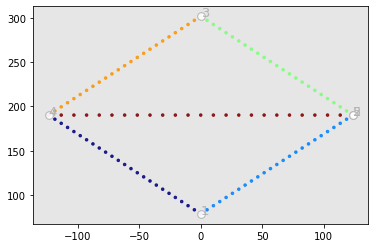

In [5]:
## === TO DEBUG HASH FUNCTION FOR TASKS...
#
# Here, give specific tasks, and will extract infor and plot.
tasklist = ["tri_sq_prog_1a_2-savedset-1-44654", "tri_sq_prog_1a_2-savedset-1-89888"]
# tasklist = ["LplusL_6-savedset-1-69344", "LplusL_6-savedset-1-38977", "LplusL_6-savedset-1-76127"]

inds = np.where(P1.pandas()["unique_task_name"].isin(tasklist).values)[0]
task1 = P1.getTrialsHelper("getTrialsTask", int(inds[0]))
taskname1 = P1.getTrialsHelper("getTrialsUniqueTasknameGood", int(inds[0]))
strokes1 = P1.getTrialsHelper("getTrialsTaskAsStrokes", int(inds[0]))
expt1 = P1.pandas()["expt"].values[inds[0]]

inds = np.where(P2.pandas()["unique_task_name"].isin(tasklist).values)[0]
task2 = P2.getTrialsHelper("getTrialsTask", int(inds[0]))
taskname2 = P2.getTrialsHelper("getTrialsUniqueTasknameGood", int(inds[0]))
strokes2 = P2.getTrialsHelper("getTrialsTaskAsStrokes", int(inds[0]))
expt2 = P2.pandas()["expt"].values[inds[0]]

print(taskname1)
print(taskname2)

print(expt1)
print(expt2)

print(task1["x"][0][0])
print(task2["x"][0][0])

print(strokes1[0][0])
print(strokes2[0][0])

# plot
fig, ax = plt.subplots()
plotDatStrokes(strokes1, ax)
plotDatStrokes(strokes2, ax, plotver="strokes")


In [ ]:
# = print all tasks within a given task category

In [15]:
taskname = "tri_sq_prog_1a"

print(set(P1.pandas()[P1.pandas()["task_stagecategory"]==taskname]["unique_task_name"]))
print(set(P2.pandas()[P2.pandas()["task_stagecategory"]==taskname]["unique_task_name"]))

{'tri_sq_prog_1a_2-savedset-1-89888', 'tri_sq_prog_1a_7-savedset-1-50165', 'tri_sq_prog_1a_6-savedset-1-89471', 'tri_sq_prog_1a_11-savedset-1-51988', 'tri_sq_prog_1a_4-savedset-1-89680', 'tri_sq_prog_1a_5-savedset-1-49252', 'tri_sq_prog_1a_8-savedset-1-89263', 'tri_sq_prog_1a_10-savedset-1-89054', 'tri_sq_prog_1a_1-savedset-1-47428', 'tri_sq_prog_1a_3-savedset-1-48340', 'tri_sq_prog_1a_9-savedset-1-51076'}
{'tri_sq_prog_1a_2-savedset-1-89888', 'tri_sq_prog_1a_11-savedset-1-51988'}


In [ ]:
# === extract all tasks that are presented across expts
expts_desired = ["lines5", "arc2", "biasdir7"]
tasklist = set(DF["unique_task_name"])
tasks_good = []
for t in tasklist:
    
    expts_with_task = set(DF[DF["unique_task_name"]==t]["expt"])
    
    if all([e in expts_with_task for e in expts_desired]):
        tasks_good.append(t)
tasks_good.sort()
[print(t) for t in tasks_good]

In [ ]:
# == plot
ncols = 4
nrows = int(np.ceil(len(tasks_good)/4))
assert nrows<10

fig, axes = plt.subplots(nrows, ncols, sharex=True, sharey=True, figsize=(ncols*2, nrows*2))
for task, ax in zip(tasks_good, axes.flatten()):
    strokes = DF[DF["unique_task_name"]==task]["strokes_task"].values[0]
    plotDatStrokes(strokes, ax, pcol="k")
    ax.set_title(task[:15])